<a href="https://colab.research.google.com/github/DongUk-Park/RnD/blob/main/ML/%EB%B0%95%EB%8F%99%EC%9A%B1_1924176_%E1%84%86%E1%85%A5%E1%84%89%E1%85%B5%E1%86%AB%E1%84%85%E1%85%A5%E1%84%82%E1%85%B5%E1%86%BC_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%85%E1%85%B5%E1%84%91%E1%85%A9%E1%84%90%E1%85%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

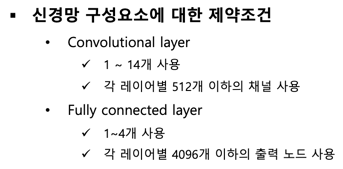

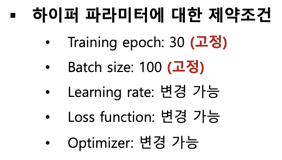

### 패키지 선언

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Dataset 다운로드

In [3]:
# Training dataset 다운로드
cifar100_train = dataset.CIFAR100(root = "./",
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar100_test = dataset.CIFAR100(root = "./",
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

100%|██████████| 169001437/169001437 [00:13<00:00, 12103724.67it/s]


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


## 신경망 모델 정의
- Fully Connected Layer -> nn.Linear(in_features, out_features)
- Convolutional Layer -> nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
- ReLU -> nn.ReLU()
- Max Pooling -> nn.MaxPool2d(kernel_size, stride)


In [4]:
class ChannelAttention(nn.Module):
  def __init__(self, channels, reduction):
    super(ChannelAttention, self).__init__()
    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels // reduction, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=channels // reduction, out_channels=channels, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    ca_out = self.gap(x)
    ca_out = self.relu(self.conv1(ca_out))
    ca_out = self.sigmoid(self.conv1(ca_out))
    ca_out = ca_out.expand_as(x)
    y = x * ca_out
    return y

In [5]:
class SimplifiedVGG_skip(nn.Module):

  def __init__(self):
    super(SimplifiedVGG_skip, self).__init__()

    # 신경망 파라미터 초기화 (Conv 6개, FC 3개, ReLU, MaxPool)
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=2)    # Convolution: [3x3x3]x16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x16]x32, s1, p1
    self.batch_norm1 = nn.BatchNorm2d(32)  # Batch Normalization added

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x64, s1, p1
    self.batch_norm2 = nn.BatchNorm2d(96)  # Batch Normalization added

    self.conv3_1 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1, padding=2)  # Convolution: [3x3x64]x128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # Convolution: [3x3x128]x256, s1, p1
    self.batch_norm3 = nn.BatchNorm2d(256)  # Batch Normalization added


    self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)  # Convolution: [3x3x64]x128, s1, p1
    self.conv4_2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) # Convolution: [3x3x128]x256, s1, p1

    self.fc1 = nn.Linear(in_features=2048, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=516)
    self.fc3 = nn.Linear(in_features=516, out_features=256)
    self.fc4 = nn.Linear(in_features=256, out_features=100)

    self.relu = nn.LeakyReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.skip1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride=1, padding=2)
    self.skip2 = nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 3, stride=1, padding=2)

    self.channel_attention1 = ChannelAttention(channels = 32, reduction = 1)
    self.channel_attention2 = ChannelAttention(channels = 96, reduction = 1)
    self.channel_attention3 = ChannelAttention(channels = 256, reduction = 1)


    self.dropout = nn.Dropout(p=0.5)  # You can adjust the dropout probability as needed

  def forward(self, x):
    #-----------------------------------------------------------------
    # Convolution, ReLU, MaxPool layer
    y_skip = self.skip1(x)
    y = self.relu(self.conv1_1(x))
    y = self.relu(self.conv1_2(y))
    #print(y.shape)
    #print(y_skip.shape)
    y = y + y_skip
    #y = self.channel_attention1(y)
    y = self.max_pool(y)

    y = self.batch_norm1(y)

    dense_y = y
    y = self.relu(self.conv2_1(y))
    y = self.relu(self.conv2_2(y))
    y = torch.cat([y, dense_y], dim = 1)
    y = self.channel_attention2(y)
    y = self.max_pool(y)

    y = self.batch_norm2(y)

    #print(y.shape)
    y_skip = self.skip2(y)
    y = self.relu(self.conv3_1(y))
    y = self.relu(self.conv3_2(y))
    y = y + y_skip
    #y = self.channel_attention3(y)
    y = self.max_pool(y)

    y = self.batch_norm3(y)
    y = self.dropout(y)

    y = self.relu(self.conv4_1(y))
    y = self.relu(self.conv4_2(y))
    y = self.max_pool(y)

    #print(y.shape)
    #-----------------------------------------------------------------

    y = y.view(-1, 2048) # feature map 평탄화

    #-----------------------------------------------------------------
    # Fully Connected, ReLU layer
    y = self.relu(self.fc1(y))
    y = self.relu(self.fc2(y))
    y = self.relu(self.fc3(y))
    y = self.fc4(y)
    #-----------------------------------------------------------------

    return y


## Hyper-parameters 지정

In [6]:
batch_size = 100      # 고정 하이퍼 파라미터
training_epochs = 30  # 고정 하이퍼 파라미터


learning_rate = 0.1
loss_function = nn.CrossEntropyLoss()
network = SimplifiedVGG_skip().to('cuda')
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

data_loader = DataLoader(dataset=cifar100_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

## CNN 학습을 위한 반복문 선언

In [7]:
for epoch in range(training_epochs):
  network.train()
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:
    img = img.to('cuda')
    label = label.to('cuda')
    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

Epoch: 1 Loss = 4.269532
Epoch: 2 Loss = 3.627626
Epoch: 3 Loss = 3.231110
Epoch: 4 Loss = 2.865081
Epoch: 5 Loss = 2.545967
Epoch: 6 Loss = 2.284142
Epoch: 7 Loss = 2.069845
Epoch: 8 Loss = 1.873649
Epoch: 9 Loss = 1.694315
Epoch: 10 Loss = 1.522493
Epoch: 11 Loss = 1.358657
Epoch: 12 Loss = 1.205674
Epoch: 13 Loss = 1.052981
Epoch: 14 Loss = 0.909384
Epoch: 15 Loss = 0.787346
Epoch: 16 Loss = 0.671727
Epoch: 17 Loss = 0.571822
Epoch: 18 Loss = 0.481088
Epoch: 19 Loss = 0.421109
Epoch: 20 Loss = 0.367007
Epoch: 21 Loss = 0.310142
Epoch: 22 Loss = 0.275181
Epoch: 23 Loss = 0.241536
Epoch: 24 Loss = 0.220962
Epoch: 25 Loss = 0.202285
Epoch: 26 Loss = 0.185927
Epoch: 27 Loss = 0.161376
Epoch: 28 Loss = 0.157200
Epoch: 29 Loss = 0.136509
Epoch: 30 Loss = 0.131166
Learning finished


## 학습이 완료된 모델을 이용해 정답률 확인

In [8]:
network.eval()
network = network.to('cuda')
img_test = torch.tensor(np.transpose(cifar100_test.data,(0,3,1,2))) / 255.
label_test = torch.tensor(cifar100_test.targets)

img_test = img_test.to('cuda')
label_test = label_test.to('cuda')

with torch.no_grad(): # test에서는 기울기 계산 제외
  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.5285999774932861
